In [1]:
import os
import torch
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.simple_keypoint_dataset import SimpleKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import generate_connection_line, get_sample_from_loader, visualize_pose
from IPython.display import display
from pathlib import Path
pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/synthetic_cabin_ir/A_Pillar_Codriver')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
# ------------
# model
# ------------
batch_size = 64
max_epoch = 10
val_check_period = 5
early_stopping_patience = 5
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_hip=True)
# ------------
# saved model path
# ------------
saved_model_path = './saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/'


train_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_train.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    image_width=1280,
    image_height=1024,
    exclude_ankle=True,
    exclude_hip=True
)
val_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_val.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_val.json').as_posix(),
    image_width=1280,
    image_height=1024,
    exclude_ankle=True,
    exclude_hip=True
)
test_dataset = SimpleKeypointDataset(
    prediction_file=(keypoint_2d_path / 'keypoint_detection_test.json').as_posix(),
    annotation_file=(keypoint_3d_path / 'person_keypoints_test.json').as_posix(),
    image_width=1280,
    image_height=1024,
    exclude_ankle=True,
    exclude_hip=True
)

print(
    'train_dataset', len(train_dataset),
    'val_dataset', len(val_dataset),
    'test_dataset', len(test_dataset)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)

model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience)


if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.fit(lit_model, train_loader, val_loader)

Global seed set to 1234
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_dataset 37499 val_dataset 6250 test_dataset 6251


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-jtz2ksw5'


check #0
val MPJPE from: 128 samples : 4060.011863708496


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/opt/conda/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/opt/conda/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-u3khs_z_'


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 2925 batches: 314.13409610079907
val MPJPE from: 6208 samples : 66.44697487354279


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


check #2
training loss from 2925 batches: 81.27195040767009
val MPJPE from: 6208 samples : 43.831028044223785


In [2]:
with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
    f.writelines(model_checkpoint.best_model_path)

In [3]:
best_checkpoint_path = model_checkpoint.best_model_path
trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)

Restoring states from the checkpoint path at saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/lightning_logs/version_1/checkpoints/epoch=9-step=5850.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/synthetic_cabin_ir/A_Pillar_Codriver/prediction/linear_model/lightning_logs/version_1/checkpoints/epoch=9-step=5850.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 47.849325183079905
PJPE
                     PJPE
nose            40.930811
left_eye        47.116935
right_eye       47.757974
left_ear        44.781503
right_ear       51.221956
left_shoulder   37.636695
right_shoulder  42.321936
left_elbow      98.741319
right_elbow     60.942211
left_wrist      54.049714
right_wrist     42.484343
left_hip        34.722864
right_hip       19.332967
activities_mpjpe:
{}
test mpjpe: 47.849325183079905


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │    47.849325183079905     │
└───────────────────────────┴───────────────────────────┘

[{'mpjpe': 47.849325183079905}]

In [4]:
# item_index, sample = get_sample_from_loader(val_loader)
sample = get_sample_from_loader(val_loader)

In [5]:
item_index = 61

In [6]:
sample = val_loader.dataset.samples[item_index]

In [9]:
gt_keypoints_3d = sample['keypoints3D']

PosixPath('/root/data/processed/synthetic_cabin_ir/A_Pillar_Codriver/images/000000003187.jpg')

In [21]:
results = generate_connection_line(sample['keypoints3D'])
coord_df = pd.DataFrame.from_records(results)[['x', 'y', 'z']]

In [22]:
coord_max = coord_df.max()
coord_min = coord_df.min()
coord_mean = coord_df.mean()
coord_range = (coord_max - coord_min) / 2
span = coord_range.max()

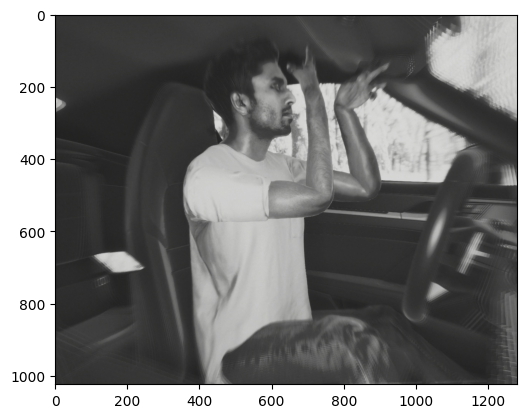

In [23]:
img_path = (dataset_root_path / 'images' / 'val' / sample['filenames']).as_posix()
plt.imshow(plt.imread(img_path))

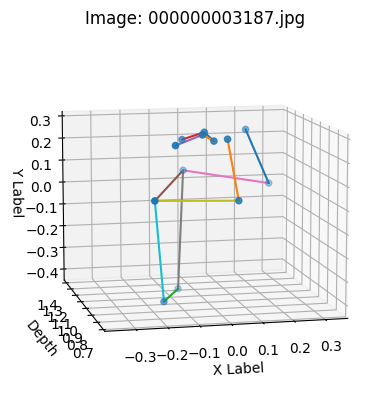

In [44]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# defining all 3 axis
depth = gt_keypoints_3d[:,2]
x = gt_keypoints_3d[:,0]
y = gt_keypoints_3d[:,1]

# plotting
ax.scatter3D(x, depth, -y, 'green')

for i in range(len(results) // 2):
# for i in range(5):
    ax.plot3D(
        [results[2*i]['x'], results[2*i + 1]['x']],
        [results[2*i]['z'], results[2*i + 1]['z']],
        [-results[2*i]['y'], -results[2*i + 1]['y']],
    )
ax.set_xlabel('X Label')
ax.set_ylabel('Depth')
ax.set_zlabel('Y Label')
ax.set_xlim([coord_mean['x'] - span, coord_mean['x'] + span])
ax.set_ylim([coord_mean['z'] - span, coord_mean['z'] + span])
ax.set_zlim([coord_mean['y'] - span, coord_mean['y'] + span])
ax.set_title(f'Image: {sample["filenames"]}')
ax.view_init(elev=10., azim= -125 + 45//2)
plt.show()

In [ ]:
results = generate_connection_line(sample['keypoints_3d'])
pose_df = pd.DataFrame(results)
visualize_pose(pose_df)

In [ ]:
model = trainer.model.to(device)
model.eval()
estimated_pose = model(torch.flatten(torch.tensor(sample['keypoints_2d'])).unsqueeze(0).float().to(device), 0)
estimated_pose_df = pd.DataFrame(generate_connection_line(estimated_pose[0].cpu().reshape([-1, 3]).detach().numpy()))
visualize_pose(estimated_pose_df)